# Q-learning
对应《强化学习的数学原理》第7章
<br>代码对应《动手学强化学习》第5章 [请点击这里](https://hrl.boyuai.com/chapter/1/%E6%97%B6%E5%BA%8F%E5%B7%AE%E5%88%86%E7%AE%97%E6%B3%95)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

# 环境
还是悬崖漫步环境

In [12]:
class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0              # 记录当前智能体位置的横坐标  。初始位置在左下角
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):  # 回归初始状态,坐标轴原点在左上角。起点在左下角。
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

# Q-learning

In [13]:
class QLearning:
    """ Q-learning算法 """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

    def take_action(self, state):  #选取下一步的操作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state):  # 用于最后打印策略，不参与训练
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1):

        td_error = r + self.gamma * self.Q_table[s1].max() - self.Q_table[s0, a0]
        # 单步Sarsa是td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

Q-learning在更新时用的是 self.Q_table[s1].max()，这个值对应的是下一个状态的最大的Q值。
<br>Sarsa这里self.Q_table[s1, a1],Q-laerning是self.Q_table[s1].max(),Sarsa在训练是多了一个next_action = agent.take_action(next_state)获得下一个状态的动作。
<br>而Q-learning在训练时没有这一步，只有next_state, reward, done = env.step(action)获得下一个状态,在更新Q时直接用下一个状态的最大的Q

在单步Sarsa中，update要传入s,a,r,s,a。下一个状态传入take_action,得到下一个动作，然后得到下一个动作值的。
<br>而在Q-laerning中，得到下一个状态后，直接取下一个状态的最大的动作值。
<br>如果在单步Sarsa的take_action，把epsilon设置为0，那么下一个状态肯定就直接取最大的动作值了。
<br>这样不就跟Q-laerning一样了吗？是这样吗？
<br>不是，即使Sarsa的epsilon=0,Sarsa和Q-learning还是不一样的。
<br>当Sarsa的epsilon=0时，它会采取动作值最大的动作，学习动作值最大的动作。
<br>而Q-laerning的epsilon不为0时，它还是学习动作值最大的动作，但是执行时是按epsilon-greedy执行。
<br>Q-laening始终学习动作值最大的动作，跟他具体执行什么动作没有关系

Sarsa是on-policy的，学习和执行的是同一个策略，下一个状态执行的动作就是学的动作。
<br>Sarsa的训练代码中next_action = agent.take_action(next_state)，然后取的这个next_state，next_action的q。然后更新。
<br>Q-learning是off-policy的，学的时候直接取的是下一个状态的最大的q,但是下一个状态实际采取的动作不一定是使得q最大的动作。

# 训练

## 实例化

In [14]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = QLearning(ncol, nrow, epsilon, alpha, gamma)

## 开始训练

In [15]:
num_episodes = 1000
return_list = []     # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条

    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()   # 每次都是从同样的起点出发
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                episode_return += reward        # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state)
                state = next_state
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({'episode':'%d' % (num_episodes / 10 * i + i_episode + 1),'return':'%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)

Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 1:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 2:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 3:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 4:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 5:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 6:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 7:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 8:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 9:   0%|          | 0/100 [00:00<?, ?it/s]

## 训练结束

### 训练过程可视化

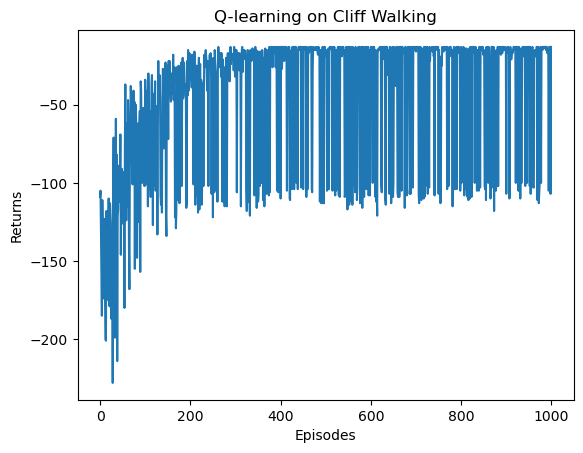

In [16]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Q-learning on {}'.format('Cliff Walking'))
plt.show()

### 打印Q-tabel

In [17]:
agent.Q_table

array([[ -6.95106309,  -6.92238896,  -6.92498903,  -6.92337824],
       [ -6.75033062,  -6.78467015,  -6.78595589,  -6.75300236],
       [ -6.5306487 ,  -6.56218204,  -6.56040494,  -6.53363876],
       [ -6.28514627,  -6.29774226,  -6.27996233,  -6.26721063],
       [ -6.01218673,  -6.00685558,  -5.97750853,  -5.96447838],
       [ -5.64269869,  -5.63369984,  -5.67274602,  -5.61284057],
       [ -5.23575103,  -5.23112669,  -5.25282688,  -5.23626603],
       [ -4.8378303 ,  -4.8271001 ,  -4.87885064,  -4.80035795],
       [ -4.34095182,  -4.35738438,  -4.3717109 ,  -4.32838589],
       [ -3.8126058 ,  -3.82612832,  -3.89819023,  -3.80817511],
       [ -3.29165671,  -3.26054745,  -3.37175401,  -3.2583015 ],
       [ -2.6769663 ,  -2.66313972,  -2.77092873,  -2.6769663 ],
       [ -7.05726686,  -7.08807202,  -7.07444966,  -7.04815862],
       [ -6.85408525,  -6.85341364,  -6.85968052,  -6.8439481 ],
       [ -6.62882759,  -6.60332796,  -6.6318673 ,  -6.60866311],
       [ -6.34350987,  -6

### 策略可视化

In [18]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()

In [19]:
action_meaning = ['^', 'v', '<', '>']
print('Q-learning算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range((nrow-1)*ncol+1, nrow*ncol-1)), [nrow*ncol-1])

Q-learning算法最终收敛得到的策略为：
ovoo ^ooo ^ooo ooo> ooo> ooo> ovoo ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ovoo ovoo ooo> ovoo ooo> ooo> ovoo ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 
